# FastAI Experiments

In [5]:
from fastai.tabular import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import os
import sys
import glob
from sklearn.utils import shuffle

## Download datasets
- if zip dataset files already exists; no download is done
- force unzip all the .zip files

In [3]:
%%bash
URL=https://iscxdownloads.cs.unb.ca/iscxdownloads/ISCX-URL-2016/
FILES=(ISCXURL2016.zip) 
for FILE in ${FILES[*]}; do
    if [ ! -f "$FILE" ]; then
        printf "downloading %s\n" $FILE
        curl -O $URL$FILE
        # unzip files
        echo 'unzipping ' $FILE
        unzip -o $FILE #overwrite exiting files/folders if exists
    fi
done

downloading ISCXURL2016.zip
unzipping  ISCXURL2016.zip
Archive:  ISCXURL2016.zip
   creating: FinalDataset/
  inflating: FinalDataset/Spam_Infogain_test.csv  
  inflating: FinalDataset/Spam_Infogain.csv  
  inflating: FinalDataset/Spam_BestFirst_test.csv  
  inflating: FinalDataset/Spam_BestFirst.csv  
  inflating: FinalDataset/Spam.csv   
  inflating: FinalDataset/Phishing_Infogain_test.csv  
  inflating: FinalDataset/Phishing_Infogain.csv  
  inflating: FinalDataset/Phishing.csv  
  inflating: FinalDataset/Malware_Infogain_test.csv  
  inflating: FinalDataset/Malware_Infogain.csv  
  inflating: FinalDataset/Malware_BestFirst.csv  
  inflating: FinalDataset/Malware.csv  
  inflating: FinalDataset/Defacement_Infogain_test.csv  
  inflating: FinalDataset/Defacement_Infogain.csv  
  inflating: FinalDataset/Defacement_BestFirst.csv  
  inflating: FinalDataset/Defacement.csv  
  inflating: FinalDataset/All_Infogain_test.csv  
  inflating: FinalDataset/All_Infogain.csv  
  inflating: FinalD

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.6M  100 10.6M    0     0  3609k      0  0:00:03  0:00:03 --:--:-- 3611k


## Check CSV files inside FinalDataset folder

In [4]:
! ls FinalDataset

All.csv                      Malware_Infogain_test.csv
All_BestFirst.csv            Phishing.csv
All_BestFirst_test.csv       Phishing_BestFirst.csv
All_Infogain.csv             Phishing_Infogain.csv
All_Infogain_test.csv        Phishing_Infogain_test.csv
Defacement.csv               Spam.csv
Defacement_BestFirst.csv     Spam_BestFirst.csv
Defacement_Infogain.csv      Spam_BestFirst_test.csv
Defacement_Infogain_test.csv Spam_Infogain.csv
Malware.csv                  Spam_Infogain_test.csv
Malware_BestFirst.csv        URL
Malware_Infogain.csv


## Analyze FinalDataset/All.csv file

In [126]:
df = pd.read_csv('FinalDataset/All.csv', low_memory=False)

In [128]:
df.shape

(36707, 80)

In [131]:
df['argPathRatio'].astype('float')

0        0.076923
1        0.058824
2        0.060606
3        0.025974
4        0.040816
5        0.033898
6        0.046512
7        0.040000
8        0.045455
9        0.090909
10       0.043478
11       0.039216
12       0.095238
13       0.105263
14       0.080000
15       0.086957
16       0.038462
17       0.083333
18       0.017241
19       0.016949
20       0.020408
21       0.012579
22       0.014815
23       0.014085
24       0.012500
25       0.018182
26       0.050000
27       0.037037
28       0.039216
29       0.036364
           ...   
36677    0.792593
36678    0.763636
36679    0.794118
36680    0.015625
36681    0.057143
36682    0.085106
36683    0.662651
36684    0.100000
36685    0.407407
36686    0.036364
36687    0.578125
36688    0.129412
36689    0.712644
36690    0.785047
36691    0.086957
36692    0.040000
36693    0.068966
36694    0.742574
36695    0.015267
36696    0.071429
36697    0.985386
36698    0.817308
36699    0.275000
36700    0.052632
36701    0

In [132]:
df.columns

Index(['Querylength', 'domain_token_count', 'path_token_count',
       'avgdomaintokenlen', 'longdomaintokenlen', 'avgpathtokenlen', 'tld',
       'charcompvowels', 'charcompace', 'ldl_url', 'ldl_domain', 'ldl_path',
       'ldl_filename', 'ldl_getArg', 'dld_url', 'dld_domain', 'dld_path',
       'dld_filename', 'dld_getArg', 'urlLen', 'domainlength', 'pathLength',
       'subDirLen', 'fileNameLen', 'this.fileExtLen', 'ArgLen', 'pathurlRatio',
       'ArgUrlRatio', 'argDomanRatio', 'domainUrlRatio', 'pathDomainRatio',
       'argPathRatio', 'executable', 'isPortEighty', 'NumberofDotsinURL',
       'ISIpAddressInDomainName', 'CharacterContinuityRate',
       'LongestVariableValue', 'URL_DigitCount', 'host_DigitCount',
       'Directory_DigitCount', 'File_name_DigitCount', 'Extension_DigitCount',
       'Query_DigitCount', 'URL_Letter_Count', 'host_letter_count',
       'Directory_LetterCount', 'Filename_LetterCount',
       'Extension_LetterCount', 'Query_LetterCount', 'LongestPathToken

In [133]:
df.shape

(36707, 80)

In [134]:
df.head()

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath,URL_Type_obf_Type
0,0,4,5,5.5,14,4.400000,4,8,3,0,...,1,0,-1,0.726298,0.784493,0.894886,0.850608,NaN,-1.0,Defacement
1,0,4,5,5.5,14,6.000000,4,12,4,0,...,0,0,-1,0.688635,0.784493,0.814725,0.859793,0.0,-1.0,Defacement
2,0,4,5,5.5,14,5.800000,4,12,5,0,...,0,0,-1,0.695049,0.784493,0.814725,0.801880,0.0,-1.0,Defacement
3,0,4,12,5.5,14,5.500000,4,32,16,0,...,0,0,-1,0.640130,0.784493,0.814725,0.663210,0.0,-1.0,Defacement
4,0,4,6,5.5,14,7.333334,4,18,11,0,...,0,0,-1,0.681307,0.784493,0.814725,0.804526,0.0,-1.0,Defacement


In [135]:
df.tail()

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath,URL_Type_obf_Type
36702,29,4,14,5.750000,12,3.666667,4,20,24,3,...,3,2,7,0.690555,0.791265,0.777498,0.690227,0.656684,0.796205,spam
36703,0,4,13,3.750000,8,8.461538,4,24,23,0,...,16,15,-1,0.665492,0.820010,0.879588,0.674400,0.674671,-1.000000,spam
36704,58,3,27,6.666666,16,3.375000,3,41,34,20,...,8,7,9,0.656807,0.801139,0.684777,0.713622,0.717187,0.705245,spam
36705,35,3,13,4.333334,9,3.600000,3,15,13,7,...,9,8,3,0.725963,0.897617,0.871049,0.745932,0.758824,0.790772,spam
36706,40,3,25,6.666666,16,3.250000,3,35,31,19,...,7,6,7,0.674351,0.801139,0.697282,0.730563,0.731481,0.769238,spam


## Clean Data
- dropped samples with Infinity values
- dropped samples with NaN values

In [136]:
def loadData(csvFile):
    pickleDump = '{}.pickle'.format(csvFile)
    if os.path.exists(pickleDump):
        df = pd.read_pickle(pickleDump)
    else:
        df = pd.read_csv(csvFile, low_memory=False)
        # clean data
        # strip the whitspaces from column names
        df = df.rename(str.strip, axis='columns')
        #df.drop(columns=[], inplace=True)
        # drop missing values/NaN etc.
        #df.dropna(inplace=True)
        # drop Infinity rows and NaN string from each column
        for col in df.columns:
            indexNames = df[df[col]=='Infinity'].index
            if not indexNames.empty:
                print('deleting {} rows with Infinity in column {}'.format(len(indexNames), col))
                df.drop(indexNames, inplace=True)
            indexNames = df[df[col]=='NaN'].index
            if not indexNames.empty:
                print('deleting {} rows with NaN in column {}'.format(len(indexNames), col))
                df.drop(indexNames, inplace=True)
        
        df.to_pickle(pickleDump)
    
    return df

## Test loadData function

In [170]:
df1 = loadData('FinalDataset/All.csv')

/Users/rbasnet/miniconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


deleting 10 rows with Infinity in column argPathRatio


In [171]:
df1.columns

Index(['Querylength', 'domain_token_count', 'path_token_count',
       'avgdomaintokenlen', 'longdomaintokenlen', 'avgpathtokenlen', 'tld',
       'charcompvowels', 'charcompace', 'ldl_url', 'ldl_domain', 'ldl_path',
       'ldl_filename', 'ldl_getArg', 'dld_url', 'dld_domain', 'dld_path',
       'dld_filename', 'dld_getArg', 'urlLen', 'domainlength', 'pathLength',
       'subDirLen', 'fileNameLen', 'this.fileExtLen', 'ArgLen', 'pathurlRatio',
       'ArgUrlRatio', 'argDomanRatio', 'domainUrlRatio', 'pathDomainRatio',
       'argPathRatio', 'executable', 'isPortEighty', 'NumberofDotsinURL',
       'ISIpAddressInDomainName', 'CharacterContinuityRate',
       'LongestVariableValue', 'URL_DigitCount', 'host_DigitCount',
       'Directory_DigitCount', 'File_name_DigitCount', 'Extension_DigitCount',
       'Query_DigitCount', 'URL_Letter_Count', 'host_letter_count',
       'Directory_LetterCount', 'Filename_LetterCount',
       'Extension_LetterCount', 'Query_LetterCount', 'LongestPathToken

In [172]:
df1.shape

(36697, 80)

In [173]:
df1['NumberRate_Extension'][:10]

0    1.0
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    1.0
Name: NumberRate_Extension, dtype: float64

In [174]:
df1.shape

(36697, 80)

In [175]:
df1.head()

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath,URL_Type_obf_Type
0,0,4,5,5.5,14,4.400000,4,8,3,0,...,1,0,-1,0.726298,0.784493,0.894886,0.850608,NaN,-1.0,Defacement
1,0,4,5,5.5,14,6.000000,4,12,4,0,...,0,0,-1,0.688635,0.784493,0.814725,0.859793,0.0,-1.0,Defacement
2,0,4,5,5.5,14,5.800000,4,12,5,0,...,0,0,-1,0.695049,0.784493,0.814725,0.801880,0.0,-1.0,Defacement
3,0,4,12,5.5,14,5.500000,4,32,16,0,...,0,0,-1,0.640130,0.784493,0.814725,0.663210,0.0,-1.0,Defacement
4,0,4,6,5.5,14,7.333334,4,18,11,0,...,0,0,-1,0.681307,0.784493,0.814725,0.804526,0.0,-1.0,Defacement


## Experimenting with FinalDataset/All.csv

## Total samples for each type

In [176]:
# total samples
label = 'URL_Type_obf_Type'
lblTypes = set(df[label])
for lbl in lblTypes:
    print('| {} | {} |'.format(lbl, len(df[df[label] == lbl].index)))

| spam | 6698 |
| phishing | 7586 |
| Defacement | 7930 |
| benign | 7781 |
| malware | 6712 |


In [177]:
dataPath = 'FinalDataset'
dep_var = label
cat_names = []
cont_names = list(set(df.columns) - set(cat_names) - set([dep_var]))

In [178]:
cont_names

['File_name_DigitCount',
 'dld_domain',
 'SymbolCount_Directoryname',
 'pathurlRatio',
 'Query_LetterCount',
 'pathLength',
 'isPortEighty',
 'NumberRate_AfterPath',
 'Entropy_Afterpath',
 'pathDomainRatio',
 'avgdomaintokenlen',
 'avgpathtokenlen',
 'NumberRate_Domain',
 'urlLen',
 'Filename_LetterCount',
 'Entropy_Domain',
 'Entropy_URL',
 'delimeter_Count',
 'Extension_LetterCount',
 'domainlength',
 'Entropy_DirectoryName',
 'URL_Letter_Count',
 'URL_DigitCount',
 'longdomaintokenlen',
 'delimeter_path',
 'ldl_path',
 'Extension_DigitCount',
 'sub-Directory_LongestWordLength',
 'URLQueries_variable',
 'ArgLen',
 'spcharUrl',
 'host_letter_count',
 'LongestVariableValue',
 'this.fileExtLen',
 'ldl_getArg',
 'ArgUrlRatio',
 'CharacterContinuityRate',
 'SymbolCount_Afterpath',
 'SymbolCount_URL',
 'executable',
 'path_token_count',
 'dld_url',
 'Entropy_Filename',
 'ldl_filename',
 'NumberRate_Extension',
 'URL_sensitiveWord',
 'ldl_domain',
 'dld_path',
 'subDirLen',
 'NumberRate_URL

In [179]:
df1['argPathRatio'] # was reading as object

0         0.07692308
1         0.05882353
2        0.060606062
3        0.025974026
4        0.040816326
5        0.033898305
6        0.046511628
7               0.04
8        0.045454547
9         0.09090909
10        0.04347826
11       0.039215688
12         0.0952381
13        0.10526316
14              0.08
15        0.08695652
16        0.03846154
17       0.083333336
18        0.01724138
19       0.016949153
20       0.020408163
21       0.012578616
22       0.014814815
23       0.014084507
24            0.0125
25       0.018181818
26              0.05
27       0.037037037
28       0.039215688
29       0.036363635
            ...     
36677      0.7925926
36678     0.76363635
36679      0.7941176
36680       0.015625
36681    0.057142857
36682     0.08510638
36683      0.6626506
36684            0.1
36685      0.4074074
36686    0.036363635
36687       0.578125
36688     0.12941177
36689      0.7126437
36690     0.78504676
36691     0.08695652
36692           0.04
36693     0.0

In [180]:
df1.argPathRatio = df1['argPathRatio'].astype('float')

In [181]:
procs = [FillMissing, Categorify, Normalize]
sss = StratifiedShuffleSplit(n_splits = 1, test_size=0.2, random_state=0)
print(sss)

StratifiedShuffleSplit(n_splits=1, random_state=0, test_size=0.2,
            train_size=None)


epoch,train_loss,valid_loss,accuracy,time
0,0.482524,0.398526,0.864033,00:06
1,0.357079,0.294653,0.899046,00:06
2,0.297282,0.240308,0.917030,00:06
3,0.240611,0.208336,0.931608,00:06
4,0.194452,0.158549,0.946322,00:06
5,0.163348,0.134551,0.954632,00:06
6,0.142602,0.107187,0.963896,00:06
7,0.111399,0.098030,0.968801,00:06
8,0.097486,0.090984,0.971117,00:05
9,0.098709,0.092126,0.970845,00:06


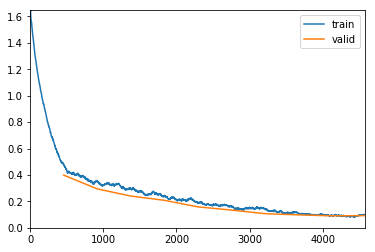

In [182]:
for train_idx, test_idx in sss.split(df1.index, df1[dep_var]):
    data_fold = (TabularList.from_df(df1, path=dataPath, cat_names=cat_names, cont_names=cont_names, procs=procs)
                     .split_by_idxs(train_idx, test_idx)
                     .label_from_df(cols=dep_var)
                     .databunch())
    # create model and learn
    model = tabular_learner(data_fold, layers=[200, 100], metrics=accuracy, callback_fns=ShowGraph)
    model.fit_one_cycle(cyc_len=10) #

In [183]:
model.save('{}.model'.format(os.path.basename(dataPath)))

In [184]:
loss, acc = model.validate()
print('loss {}: accuracy: {:.2f}%'.format(loss, acc*100))

loss 0.09212590754032135: accuracy: 97.08%


In [185]:
preds, y, losses = model.get_preds(with_loss=True)
interp = ClassificationInterpretation(model, preds, y, losses)

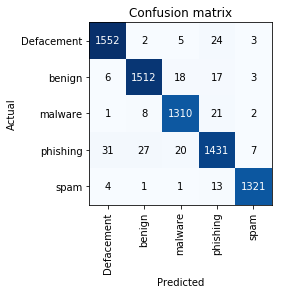

In [186]:
interp.plot_confusion_matrix(slice_size=10)

In [187]:
print(interp.confusion_matrix())

[[1552    2    5   24    3]
 [   6 1512   18   17    3]
 [   1    8 1310   21    2]
 [  31   27   20 1431    7]
 [   4    1    1   13 1321]]


In [188]:
interp.most_confused()

[('phishing', 'Defacement', 31),
 ('phishing', 'benign', 27),
 ('Defacement', 'phishing', 24),
 ('malware', 'phishing', 21),
 ('phishing', 'malware', 20),
 ('benign', 'malware', 18),
 ('benign', 'phishing', 17),
 ('spam', 'phishing', 13),
 ('malware', 'benign', 8),
 ('phishing', 'spam', 7),
 ('benign', 'Defacement', 6),
 ('Defacement', 'malware', 5),
 ('spam', 'Defacement', 4),
 ('Defacement', 'spam', 3),
 ('benign', 'spam', 3),
 ('Defacement', 'benign', 2),
 ('malware', 'spam', 2),
 ('malware', 'Defacement', 1),
 ('spam', 'benign', 1),
 ('spam', 'malware', 1)]

## Binary-class classification
- Label all malicious types as 1
- Label benign type as 0

In [189]:
lblTypes = list(lblTypes)
#lblTypes.remove('benign')
lblTypes

['spam', 'phishing', 'Defacement', 'benign', 'malware']

In [190]:
lblTypes = dict(zip(lblTypes, [1, 1, 1, 1, 1]))
lblTypes['benign'] = 0
lblTypes

{'spam': 1, 'phishing': 1, 'Defacement': 1, 'benign': 0, 'malware': 1}

In [191]:
df1[label] = df1[label].map(lblTypes)

In [192]:
df1.tail()

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath,URL_Type_obf_Type
36702,29,4,14,5.750000,12,3.666667,4,20,24,3,...,3,2,7,0.690555,0.791265,0.777498,0.690227,0.656684,0.796205,1
36703,0,4,13,3.750000,8,8.461538,4,24,23,0,...,16,15,-1,0.665492,0.820010,0.879588,0.674400,0.674671,-1.000000,1
36704,58,3,27,6.666666,16,3.375000,3,41,34,20,...,8,7,9,0.656807,0.801139,0.684777,0.713622,0.717187,0.705245,1
36705,35,3,13,4.333334,9,3.600000,3,15,13,7,...,9,8,3,0.725963,0.897617,0.871049,0.745932,0.758824,0.790772,1
36706,40,3,25,6.666666,16,3.250000,3,35,31,19,...,7,6,7,0.674351,0.801139,0.697282,0.730563,0.731481,0.769238,1


## Experiment with Malware.csv Dataset

epoch,train_loss,valid_loss,accuracy,time
0,0.161566,0.140771,0.948501,00:06
1,0.115366,0.093219,0.966076,00:06
2,0.093722,0.084552,0.965123,00:06
3,0.091745,0.066750,0.976839,00:06
4,0.068951,0.056295,0.981471,00:06
5,0.068832,0.053565,0.982016,00:06
6,0.047883,0.046450,0.985695,00:06
7,0.036764,0.044580,0.985695,00:06
8,0.034338,0.040647,0.987602,00:06
9,0.030169,0.040975,0.988283,00:06


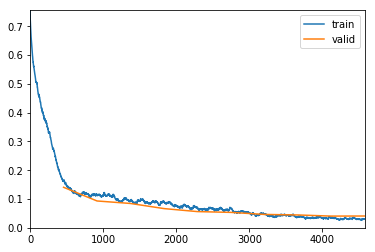

In [193]:
for train_idx, test_idx in sss.split(df1.index, df1[dep_var]):
    data_fold = (TabularList.from_df(df1, path=dataPath, cat_names=cat_names, cont_names=cont_names, procs=procs)
                     .split_by_idxs(train_idx, test_idx)
                     .label_from_df(cols=dep_var)
                     .databunch())
    # create model and learn
    model = tabular_learner(data_fold, layers=[200, 100], metrics=accuracy, callback_fns=ShowGraph)
    model.fit_one_cycle(cyc_len=10)

In [194]:
loss, acc = model.validate()
print('loss {}: accuracy: {:.2f}%'.format(loss, acc*100))

loss 0.04097536951303482: accuracy: 98.83%


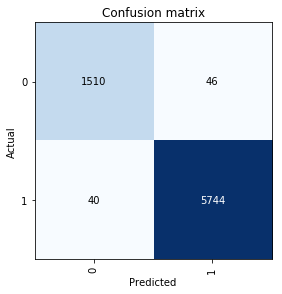

In [195]:
preds, y, losses = model.get_preds(with_loss=True)
interp = ClassificationInterpretation(model, preds, y, losses)
interp.plot_confusion_matrix(slice_size=10)

In [196]:
df1.shape

(36697, 80)